<a href="https://colab.research.google.com/github/lukaszplust/Projects/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

In [2]:
images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [3]:
#([2, 70, 120, 3])
# 2 -> 2 przykładowe obrazy
# 70 x 120 -> każdy obraz ma rozmiar 70 x 120
# 3 -> 3 kanały (mapy cech) -> (czerwony, zielony, niebieski)
images.shape

TensorShape([2, 70, 120, 3])

Tworzę dwuwymiarową warstwę splotową i przekazuje jej obrazy

Dwuwymiarowa warstwa splotowa -> 'dwuwymiarowa' odnosi się do liczby wymiarów przestrzennych (wysokość, szerokość).

Natomiast, co może być mylące, widać, że dodatkowe 2 wymiary to rozmiar grupy (1 wymiar) i kanały (4 wymiar)

In [4]:
# Warstwa splotowa zawiera:
# 32 filtry -> filters = 32
# każdy o rozmiarze 7 x 7 -> kernel_size = 7 <=> kernel_size = (7,7)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [5]:
# Teraz mam 32 kanały (mapy cech)
# Zamiast intensywności kolorów, mam intensywność każdej cechy w każdej lokacji

# Wysokość oraz szerokość zmniejszone o 6, ponieważ warstwa Conv2D
# domyślnie nie wykorzystuje uzupełnienia zerami, co oznacza, że tracimy po kilka pikseli na
# krawędziach wynikowych map cech, w zależności od rozmiarów filtrów.

# Gdy rozmiar jądra wynosi 7, trace po 6 pikseli w pionie i poziomie (po 3 piksele przy każdej krawędzi)
fmaps.shape

TensorShape([2, 64, 114, 32])

In [6]:
# padding = "valid" -> brak uzupełnienia zerami

# padding = "same" -> dane wejściowe uzupełnione z każdej strony wystarczającą liczbą zer,
# aby mapy cech miały taki sam rozmiar jak obrazy wejściowe
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding = "same")
fmaps = conv_layer(images)

fmaps.shape

TensorShape([2, 70, 120, 32])

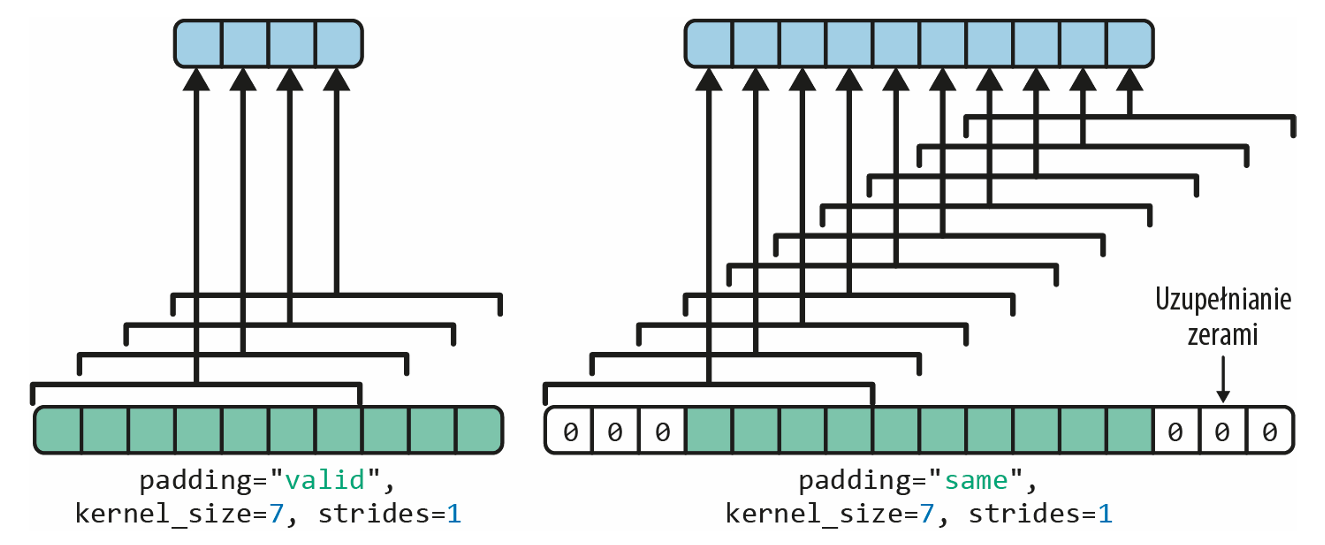

$$
z_{i,j,k} = b_k \sum_{u=0}^{f_h - 1} \sum_{v=0}^{f_w - 1} \sum_{k'=0}^{f_{n'} - 1} x_{i',j',k'} \cdot w_{u,v,k',k},
\quad \text{gdzie} \quad
\begin{cases}
i' = i \times s_h + u \\
j' = j \times s_w + v
\end{cases}
$$



In [7]:
kernels, biases = conv_layer.get_weights()

In [8]:
# BRAK WYSOKOSCI I SZEROKOSCI, ponieważ wszystkie neurony w wyjściowych mapach cech współdzielą te same wagi
# Zatem mogę dostarczać do tej warstwy obrazy o dowolnych rozmiarach
# (pod warunkiem, ze są tak duże jak jądra i posiadają odpowiednia liczbę kanałów !!!)

# [wysokosc jadra, szerokosc jadra, kanaly wejsciowe, kanaly wyjsciowe]
kernels.shape

(7, 7, 3, 32)

In [9]:
# liczba kanały wyjściowe = liczba wyjścowych map cech = liczba filtrów

# [kanaly wyjsciowe]
biases.shape

(32,)

Watstwa łącząca (Pooling layers)

Celem warstwy POOLING LAYERS jest SUBSAMPLE - zmniejszenie obrazu wejściowego w celu zredukowania obciążenia obliczeniowego, wykorzystania pamięci i liczby parametrów.

Jej jedyne zadanie to gromadzenie danych wejściowych za pomocą jakieś funkcji agregacyjnej (np. maksymalizacyjna).

Klasyfikacja za pomocą gotowej sieci Xception

In [10]:
rm -r ~/tensorflow_datasets/celeb_a

rm: cannot remove '/root/tensorflow_datasets/celeb_a': No such file or directory


In [11]:
import tensorflow_datasets as tfds
# lista datasetow
print(tfds.list_builders())

['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'ai2dcaption', 'aloha_mobile', 'amazon_us_reviews', 'anli', 'answer_equivalence', 'arc', 'asqa', 'asset', 'assin2', 'asu_table_top_converted_externally_to_rlds', 'austin_buds_dataset_converted_externally_to_rlds', 'austin_sailor_dataset_converted_externally_to_rlds', 'austin_sirius_dataset_converted_externally_to_rlds', 'bair_robot_pushing_small', 'bc_z', 'bccd', 'beans', 'bee_dataset', 'beir', 'berkeley_autolab_ur5', 'berkeley_cable_routing', 'berkeley_fanuc_manipulation', 'berkeley_gnm_cory_hall', 'berkeley_gnm_recon', 'berkeley_gnm_sac_son', 'berkeley_mvp_converted_externally_to_rlds', 'berkeley_rpt_converted_externally_to_rlds', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'ble_wind_field', 'blimp', 'booksum', 'bool_q', 'bot_adversarial_dialogue', 'bridge', 'bridge_data_msr', 'bucc', 'c4', 'c4_wsrs', 'caltech101', 'caltech_birds2010', 'caltech

In [12]:
import tensorflow_datasets as tfds

#dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset, info = tfds.load("imagenette", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/9469 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/full-size-v2/incomplete.1EHBRX_1.0.0/imagenette-train.tfrecord*…

Generating validation examples...:   0%|          | 0/3925 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/full-size-v2/incomplete.1EHBRX_1.0.0/imagenette-validation.tfre…

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0. Subsequent calls will reuse this data.


In [13]:
#dataset

In [14]:
#info

In [15]:
# podzial: początkowe 10% na testowanie, następne 15% na walidacje, pozostałe 75% na uczenie

test_set_raw, valid_set_raw, train_set_raw = tfds.load(
"imagenette",
split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
as_supervised=True)

In [16]:
dataset_size

9469

In [17]:
class_names

['n01440764',
 'n02102040',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257']

In [18]:
wnid_to_label = {
    "n01440764": "tench (ryba)",
    "n02102040": "English springer spaniel (pies)",
    "n02979186": "cassette player (odtwarzacz kaset)",
    "n03000684": "chain saw (piła łańcuchowa)",
    "n03028079": "church (kościół)",
    "n03394916": "French horn (róg francuski)",
    "n03417042": "garbage truck (śmieciarka)",
    "n03425413": "gas pump (dystrybutor paliwa)",
    "n03445777": "golf ball (piłka golfowa)",
    "n03888257": "parachute (spadochron)",
}
# zmiana kodów na czytelne nazwy
class_names = [wnid_to_label[wnid] for wnid in class_names]

In [19]:
class_names

['tench (ryba)',
 'English springer spaniel (pies)',
 'cassette player (odtwarzacz kaset)',
 'chain saw (piła łańcuchowa)',
 'church (kościół)',
 'French horn (róg francuski)',
 'garbage truck (śmieciarka)',
 'gas pump (dystrybutor paliwa)',
 'golf ball (piłka golfowa)',
 'parachute (spadochron)']

In [20]:
n_classes

10

In [21]:
#info

Wygląd zbioru walidacyjnego

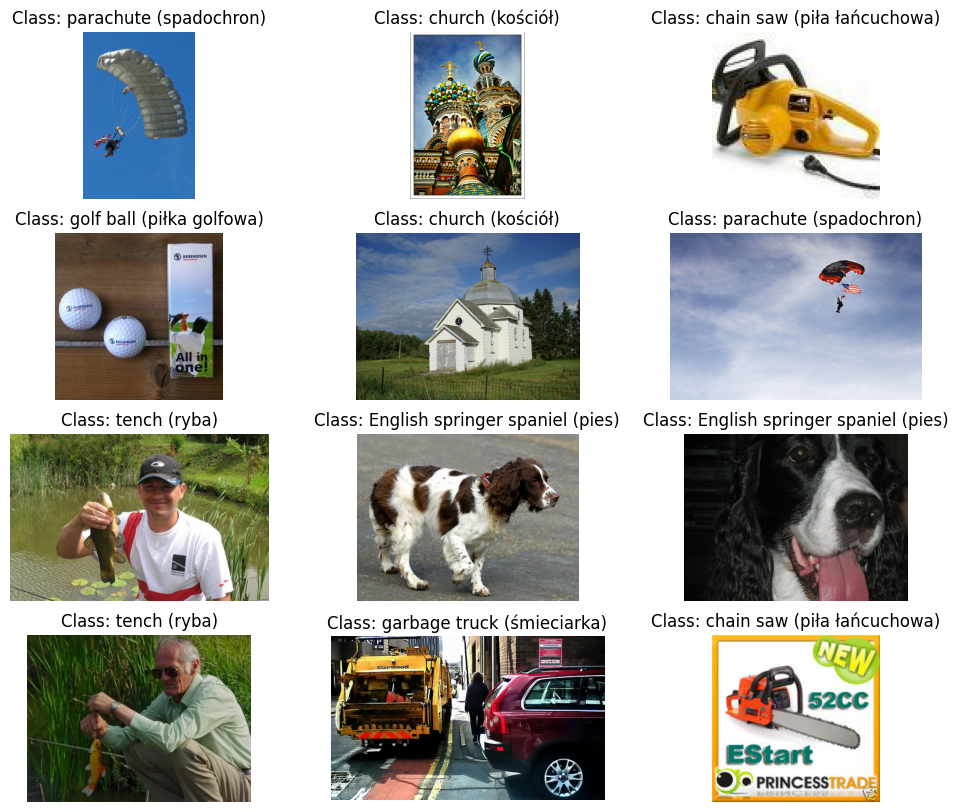

In [22]:
import matplotlib.pyplot as plt

# wyglad zbioru walidacyjnego

plt.figure(figsize=(12, 10))
index = 0
# iteruje przez 12 pierwszych obrazow i ich etykiety
for image, label in valid_set_raw.take(12):
    index += 1
    plt.subplot(4, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

In [23]:
import tensorflow as tf

# upewniam się, że poprzednie modele nie obciążają pamięci i nie wpływają na nowy model
tf.keras.backend.clear_session()

## Xception

In [24]:
# najpierw muszę się upewnić, że obrazy maja takie same rozmiary, poniewaz bez tego tworzenie grup sie nie powiedzie
# w tym celu uzywam Resising

# liczba obrazow przetwarzanych w 1 paczce
batch_size = 32

preprocess = tf.keras.Sequential([
    # przeskalowanie obrazu do rozmiaru 224 x 224
    # crop_to_aspect_ratio=True – brak deformowania obrazu, zachowuje proporcje, przycinając go, jeśli to konieczne
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    # wstepne przetowrzenie obrazu z mysla o modelu Xception
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
# musze wymieszac dane w losowej kolejności, aby model nie uczył się przypadkowych wzorców w kolejności obrazów
# .batch(batch_size) -> grupuje dane w paczki wstępnie ładując 1 batch danych do pamięci
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

In [25]:
# dogenerowanie danych

data_augmentation = tf.keras.Sequential([
    # odbijam obraz w poziomie z prawdopodobienstwem 50%
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    # losowo obracam obraz o maksymalnie 5% kata pelnego (0.05 * 360 = 18 stopni)
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    # losowo zmieniam kontrast obrazu o +,- 20%
    #tf.keras.layers.RandomContrast(factor=0.2, seed=42),
    # powieksza lub zmniejsza obraz w zakresie +,- 20%
    #tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2, seed=42),
    # zmiana jasnosci o +, - 20%
    #tf.keras.layers.RandomBrightness(factor=0.2, seed=42)
])

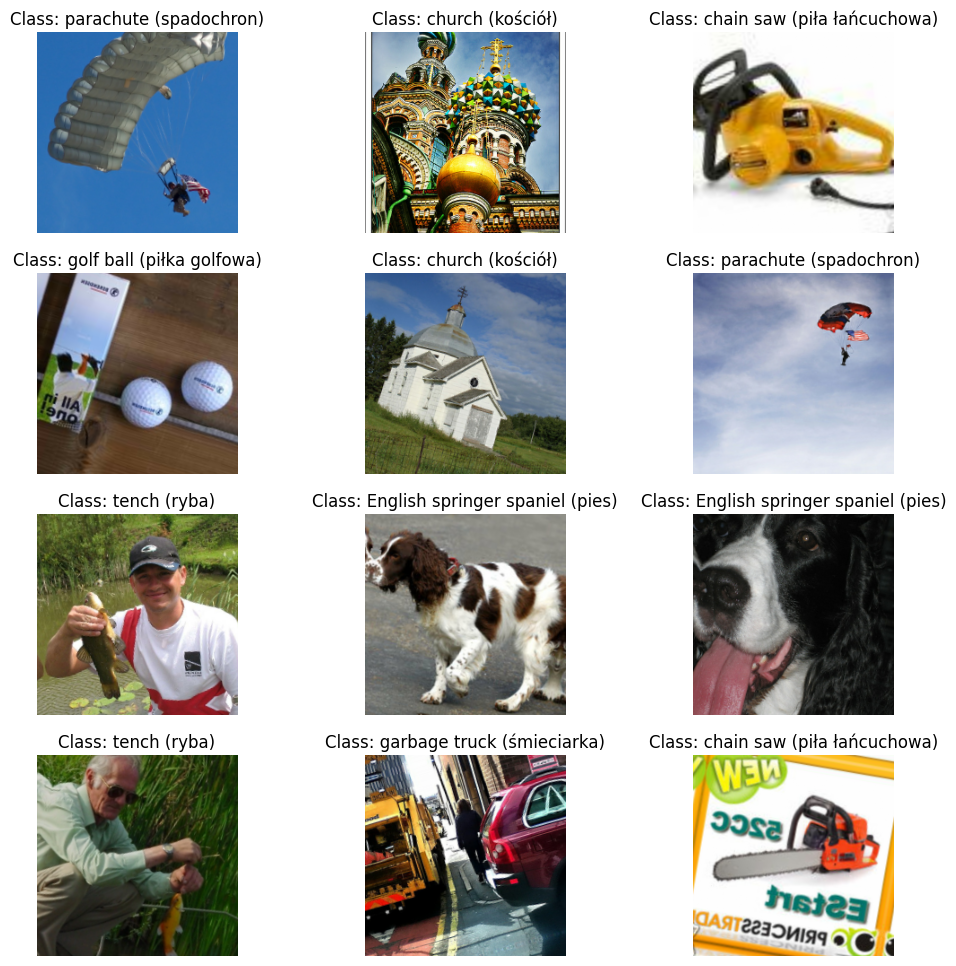

In [26]:
# widok po augumentacji
import numpy as np

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(12):
        plt.subplot(4, 3, index + 1)

        # przeskalowanie do  0-1
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

load the pretrained model, without its top layers

In [27]:
# wczytuje model Xception, wytrenowany na zestawie danych ImageNet
# wykluczam górną część sieci poprzez wyznaczenie parametru include_top=False, poniewaz
# dzieki temu pomijam globalną uśredniającą warstwę łączącą i gęstą warstwę wyjściową
# weights="imagenet" -> laduje wagi z wcześniej wytrenowanego modelu

base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)

# konwertuje wyjście z konwolucji na jednowymiarowy wektor przez uśrednianie wartości
# jest to alternatywa dla Flatten(), ale redukuje liczbe parametrow, co poprawi generalizacje

# jest to warstwa globalnego usredniania
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

# dodanie w pelni polaczonej warstwy gestej o 'n_classes' neuronach, gdzie kazdy neuron odpowiada jednej klasie
# softmax konwertuje wyjscie na prawdopodobienstwo przynaleznosci do klasy
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)

# utworzenie nowego modelu keras
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
# dobra praktyka jest zamrazanie wag wytrenowanych warstw (w szczegolnosci na poczatku procesu uczenia).
# stosuje sie to w szczegolnosci w przypadku transfer learningu poniewaz model juz nauczyl sie ogolnych
# cech i nie ma potrzeby trenowania ich od nowa

for layer in base_model.layers:
    layer.trainable = False

In [29]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
222/222 ━━━━━━━━━━━━━━━━━━━━ 86s 303ms/step - accuracy: 0.9365 - loss: 0.1894 - val_accuracy: 0.9880 - val_loss: 0.0487
Epoch 2/3
222/222 ━━━━━━━━━━━━━━━━━━━━ 44s 183ms/step - accuracy: 0.9940 - loss: 0.0232 - val_accuracy: 0.9908 - val_loss: 0.0328
Epoch 3/3
222/222 ━━━━━━━━━━━━━━━━━━━━ 78s 162ms/step - accuracy: 0.9996 - loss: 0.0024 - val_accuracy: 0.9915 - val_loss: 0.0324


In [31]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer_2          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

# Początkowe warstwy
block1_conv1, block1_conv1_bn, block1_conv1_act – konwolucja, batch normalization, aktywacja

block1_conv2, block1_conv2_bn, block1_conv2_act – kolejna konwolucja

# Warstwy separowalnych konwolucji (sepconv)

block2_sepconv1, block2_sepconv2 – separowalne konwolucje w kolejnych blokach

block2_sepconv1_bn, block2_sepconv2_bn – batch normalization dla konwolucji

# Operacje dodawania
add_1, add_2 – operacje skip connection (ResNet-like), dodawanie warstw

# Pooling i Batch Normalization
block4_pool, block13_pool – warstwy pooling zmniejszające wymiar

batch_normalization_1, batch_normalization_2 – normalizacja

# Końcowe warstwy

block14_sepconv1, block14_sepconv2 – ostatnie konwolucje

conv2d_3 – prawdopodobnie ostatnia warstwa konwolucyjna przed wyjściem

In [32]:
# Często w transfer learningu zamraża się pierwsze warstwy (layer.trainable = False), aby zachować wstępnie wyuczone cechy
# Odblokowanie końcowych warstw pozwala je dostroić do nowego zbioru danych

# Wszystkie warstwy modelu od indeksu 56 do końca bedą trenowalne
for layer in base_model.layers[56:]:
    layer.trainable = True

In [33]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 100s 343ms/step - accuracy: 0.9829 - loss: 0.0618 - val_accuracy: 0.9852 - val_loss: 0.0442
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 70s 300ms/step - accuracy: 0.9944 - loss: 0.0140 - val_accuracy: 0.9901 - val_loss: 0.0298
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 81s 302ms/step - accuracy: 0.9985 - loss: 0.0060 - val_accuracy: 0.9915 - val_loss: 0.0269
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 72s 308ms/step - accuracy: 0.9988 - loss: 0.0040 - val_accuracy: 0.9901 - val_loss: 0.0319
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 81s 310ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9901 - val_loss: 0.0392
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 73s 317ms/step - accuracy: 0.9990 - loss: 0.0027 - val_accuracy: 0.9908 - val_loss: 0.0297
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 86s 330ms/step - accuracy: 1.0000 - loss: 8.4887e-04 - val_accuracy: 0.9923 - val_loss: 0.0250
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 77s 312ms/step - accuracy: 0.9999 - lo

In [35]:
# zapis modeluXception
model.save("model_Xception.keras")

In [ ]:
# pozniejszy odczyt modelu Xception
from tensorflow import keras
model = keras.models.load_model("model_Xception.keras")

## ResNet

In [78]:
import tensorflow as tf

# upewniam się, że poprzednie modele nie obciążają pamięci i nie wpływają na nowy model
tf.keras.backend.clear_session()

In [79]:
print(tfds.list_builders())

['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'ai2dcaption', 'aloha_mobile', 'amazon_us_reviews', 'anli', 'answer_equivalence', 'arc', 'asqa', 'asset', 'assin2', 'asu_table_top_converted_externally_to_rlds', 'austin_buds_dataset_converted_externally_to_rlds', 'austin_sailor_dataset_converted_externally_to_rlds', 'austin_sirius_dataset_converted_externally_to_rlds', 'bair_robot_pushing_small', 'bc_z', 'bccd', 'beans', 'bee_dataset', 'beir', 'berkeley_autolab_ur5', 'berkeley_cable_routing', 'berkeley_fanuc_manipulation', 'berkeley_gnm_cory_hall', 'berkeley_gnm_recon', 'berkeley_gnm_sac_son', 'berkeley_mvp_converted_externally_to_rlds', 'berkeley_rpt_converted_externally_to_rlds', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'ble_wind_field', 'blimp', 'booksum', 'bool_q', 'bot_adversarial_dialogue', 'bridge', 'bridge_data_msr', 'bucc', 'c4', 'c4_wsrs', 'caltech101', 'caltech_birds2010', 'caltech

In [80]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('cifar10', as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [81]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
"cifar10",
split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
as_supervised=True)

In [82]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [87]:
# najpierw muszę się upewnić, że obrazy maja takie same rozmiary, poniewaz bez tego tworzenie grup sie nie powiedzie
# w tym celu uzywam Resising

# liczba obrazow przetwarzanych w 1 paczce
batch_size = 32

preprocess = tf.keras.Sequential([
    # przeskalowanie obrazu do rozmiaru 224 x 224
    # crop_to_aspect_ratio=True – brak deformowania obrazu, zachowuje proporcje, przycinając go, jeśli to konieczne
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    # wstepne przetowrzenie obrazu z mysla o modelu resnet50
    tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input),
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
# musze wymieszac dane w losowej kolejności, aby model nie uczył się przypadkowych wzorców w kolejności obrazów
# .batch(batch_size) -> grupuje dane w paczki wstępnie ładując 1 batch danych do pamięci
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

In [88]:
# dogenerowanie danych

data_augmentation = tf.keras.Sequential([
    # odbijam obraz w poziomie z prawdopodobienstwem 50%
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    # losowo obracam obraz o maksymalnie 5% kata pelnego (0.05 * 360 = 18 stopni)
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    # losowo zmieniam kontrast obrazu o +,- 20%
    #tf.keras.layers.RandomContrast(factor=0.2, seed=42),
    # powieksza lub zmniejsza obraz w zakresie +,- 20%
    #tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2, seed=42),
    # zmiana jasnosci o +, - 20%
    #tf.keras.layers.RandomBrightness(factor=0.2, seed=42)
])

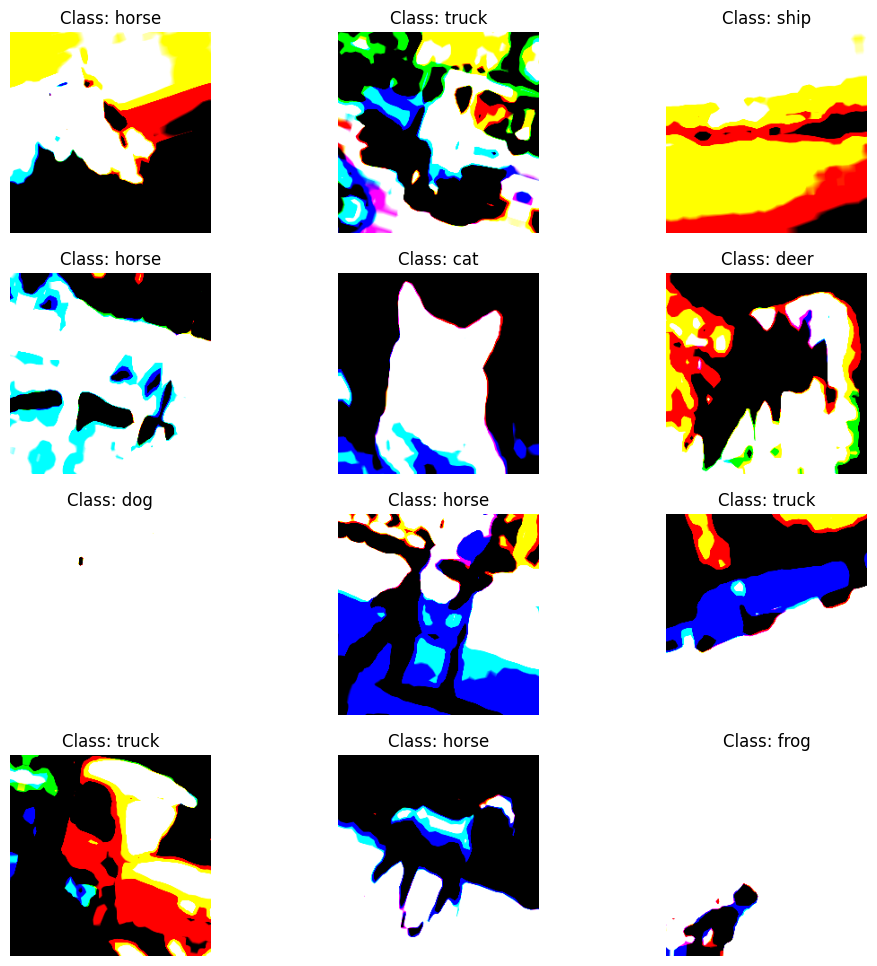

In [91]:
# widok po augumentacji
import numpy as np

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(12):
        plt.subplot(4, 3, index + 1)

        # Skala z [-1, 1] do [0, 1]
        plt.imshow((X_batch_augmented[index] + 1) / 2)
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()